Importing Libraries

In [119]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report, roc_auc_score

Load MNIST dataset

In [21]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Preprocessing 

In [22]:
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Define the CNN architecture

In [108]:
class ConvolutionalNeuralNetwork:
    def __init__(self):
        self.conv_filter = np.random.randn(3, 3) / 9
        self.conv_bias = np.zeros((1, 1, 1))
        self.fc_weights = np.random.randn(676, 10) / 676  # Adjusted dimensions
        self.fc_bias = np.zeros((10, 1))

    def forward(self, X):
        self.X = X
        self.conv_output = np.zeros((X.shape[0], 26, 26, 1))
        for i in range(26):
            for j in range(26):
                self.conv_output[:, i, j, 0] = np.sum(X[:, i:i+3, j:j+3, 0] * self.conv_filter, axis=(1, 2)) + self.conv_bias
        self.conv_output_relu = np.maximum(0, self.conv_output)
        self.fc_input = self.conv_output_relu.reshape(X.shape[0], -1)
        self.fc_output = np.dot(self.fc_input, self.fc_weights) + self.fc_bias.T  # Adjusted dot product
        self.softmax_output = np.exp(self.fc_output) / np.sum(np.exp(self.fc_output), axis=1, keepdims=True)
        return self.softmax_output

    def backward(self, y):
        grad_fc_output = self.softmax_output - y  # Remove transpose operation
        grad_fc_weights = np.dot(grad_fc_output.T, self.fc_input) / len(y)  # Transpose grad_fc_output
        grad_fc_bias = np.sum(grad_fc_output, axis=0) / len(y)
        grad_fc_input = np.dot(grad_fc_output, self.fc_weights.T)  # Adjusted dot product
        grad_conv_output_relu = grad_fc_input.reshape(self.X.shape[0], 26, 26, 1)
        grad_conv_output = grad_conv_output_relu * (self.conv_output > 0)
        grad_conv_filter = np.zeros((3, 3, 1)) # Adjusted shape
        grad_conv_bias = np.zeros((1, 1, 1))
        for i in range(26):
            for j in range(26):
                grad_conv_filter += np.sum(grad_conv_output[:, i:i+1, j:j+1, :] * self.X[:, i:i+3, j:j+3, :], axis=0)
                grad_conv_bias += np.sum(grad_conv_output[:, i:i+1, j:j+1, :], axis=(0, 1, 2))
        grad_conv_filter /= len(y)
        grad_conv_bias /= len(y)
        return grad_fc_weights, grad_fc_bias, grad_conv_filter, grad_conv_bias


    def update_params(self, grad_fc_weights, grad_fc_bias, grad_conv_filter, grad_conv_bias, learning_rate):
        self.fc_weights -= learning_rate * grad_fc_weights.T
        self.fc_bias -= learning_rate * grad_fc_bias.reshape(-1, 1)
        self.conv_filter -= learning_rate * grad_conv_filter[:, :, 0]  # Adjusted shape


Train the CNN

In [109]:
def train(model, X_train, y_train, epochs, learning_rate, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            output = model.forward(X_batch)
            grad_fc_weights, grad_fc_bias, grad_conv_filter, grad_conv_bias = model.backward(y_batch)
            model.update_params(grad_fc_weights, grad_fc_bias, grad_conv_filter, grad_conv_bias, learning_rate)

Test the CNN

In [110]:
def test(model, X_test, y_test):
    y_pred = []
    for i in range(len(X_test)):
        output = model.forward(X_test[i:i+1])
        prediction = np.argmax(output)
        y_pred.append(prediction)
    return np.array(y_pred), y_test.argmax(axis=1)

Initialize and train the model

In [111]:
cnn_model = ConvolutionalNeuralNetwork()
train(cnn_model, X_train, y_train, epochs=5, learning_rate=0.01, batch_size=32)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


Test the model

In [112]:
y_pred, y_true = test(cnn_model, X_test, y_test)

Accuracy

In [113]:
accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9125


Confusion Matrix

In [114]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 969    0    0    1    0    3    5    1    1    0]
 [   0 1118    2    3    0    1    4    1    5    1]
 [  10   21  885   32   10    3   12    8   43    8]
 [   4    0   15  917    1   43    1    9    7   13]
 [   3    2    3    2  898    0   11    2    6   55]
 [   9    4    3   22    9  803    8    2   22   10]
 [  16    3    5    1    8   30  892    2    1    0]
 [   2   12   20   11    7    2    0  909    3   62]
 [   9   20    4   37   11   65    8    6  792   22]
 [  11   10    1    8   18    9    0    8    2  942]]


Classification Report

In [115]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.94      0.99      0.96      1135
           2       0.94      0.86      0.90      1032
           3       0.89      0.91      0.90      1010
           4       0.93      0.91      0.92       982
           5       0.84      0.90      0.87       892
           6       0.95      0.93      0.94       958
           7       0.96      0.88      0.92      1028
           8       0.90      0.81      0.85       974
           9       0.85      0.93      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



ROC Curve and AUC

In [121]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

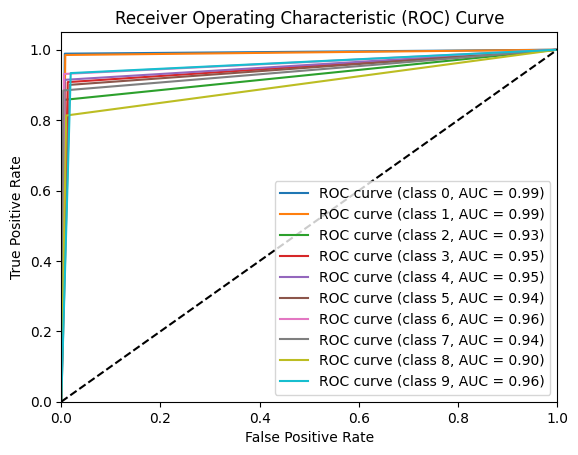

In [117]:
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class %d, AUC = %.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Correlation Matrix

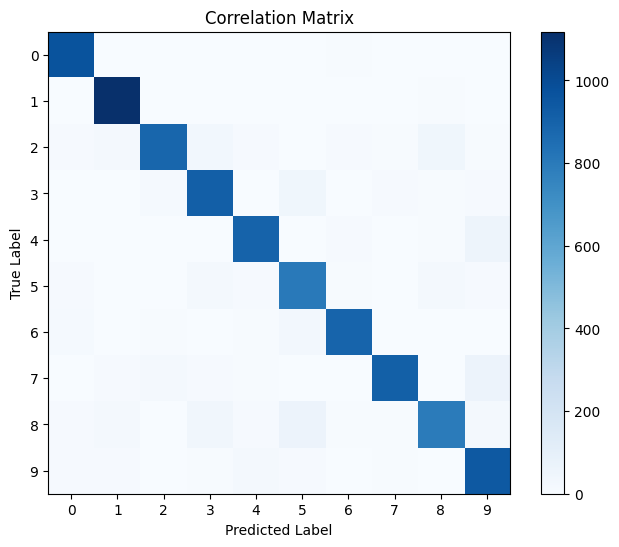

In [118]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Correlation Matrix')
plt.colorbar()
plt.xticks(np.arange(10), np.arange(10))
plt.yticks(np.arange(10), np.arange(10))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()